<a href="https://colab.research.google.com/github/Rpmalukani22/Reinforcement_Learning_CartPole_game/blob/main/Reinforcement_Learning_CartPole_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning - CartPole game

In [1]:
# !pip install -U gym
import gym
import random
import numpy as np
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
%matplotlib inline

## Display settings

In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()


## Random game play

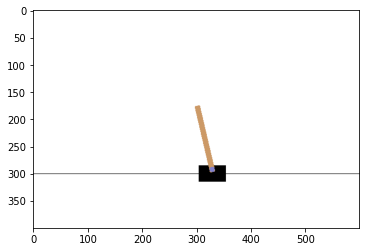

In [3]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()

In [4]:
env = gym.make("CartPole-v1")

In [5]:
def playEpisode():
  state=env.reset()
  done=False
  score=0
  while not done:
    # env.render()
    action=random.choice([0,1])
    new_state,reward,done,info = env.step(action)
    score+=1
  # print("Episode score : ",score)
  env.close()
  return score

In [6]:
n_episodes=100
sum=0
for episode in range(n_episodes):
  sum+=playEpisode()
print(f"Avg score for {n_episodes} episodes",sum/n_episodes)

Avg score for 100 episodes 21.78


### Observation: Avg score for 100 episode is approximately 22. We can train a model which can learn to play this game to achieve better score.

## Reinforcement Learning using Deep Q Learning Algorithm
* Bellman equation `Q(s,a) = r + gamma*(max(Q(s',a')))`

In [7]:
from collections import deque
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

In [9]:
#Environment params
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n
n_states,n_actions

(4, 2)

In [17]:
#defining hyperparameters
gamma=0.95 #discount rate for the reward which is comparatively far from current reward
epsilon=1.0 #how much % random action should be taken
min_epsilon=0.01 #minimum % of random choice
epsilon_decay_rate=0.99 #rate of reduction for epsilon
buffer_size=20000
n_episodes=500
batch_size=32

In [18]:
#function define the model architecture
def get_agent(n_states,n_actions):
  model=tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(16,input_dim=n_states,activation='relu'))
  model.add(tf.keras.layers.Dense(16,activation='relu'))
  model.add(tf.keras.layers.Dense(16,activation='relu'))
  model.add(tf.keras.layers.Dense(n_actions,activation='linear'))
  return model


In [19]:
def get_action(model,state,epsilon,n_actions,n_states):
  if np.random.rand()<=epsilon:
    return random.randrange(n_actions)
  else:
    return np.argmax(model.predict(state.reshape(1,n_states))[0])

In [20]:
def memorize(training_data,state,action,next_state,reward,done):
  training_data.append((state,action,next_state,reward,done))

In [21]:
def train_on_batch(model,training_data,batch_size,n_states,min_epsilon,epsilon_decay_rate):
  global epsilon
  idx = random.sample(range(len(training_data)),min(len(training_data),batch_size))
  train_batch = [training_data[i] for i in idx]
  for move in train_batch:
    state,action,next_state,reward,done = move
    y_train_value = reward #target value for a single action
    if not done:
      y_train_value = reward + gamma*(np.max(model.predict(next_state.reshape(1,n_states))[0]))
    y_train = model.predict(state.reshape(1,n_states)) #results all actions
    y_train[0][action] = y_train_value #supervision on single action
    model.fit(state.reshape(1,n_states),y_train,epochs=1,verbose=0)
  if epsilon>min_epsilon:
    epsilon*=epsilon_decay_rate



In [26]:
def train():
  try:
    global epsilon
    tf.keras.backend.clear_session()
    agent =get_agent(n_states,n_actions)
    agent.compile(loss='mse',optimizer='adam')
    training_data=deque(maxlen=buffer_size)
    scores=[]
    for episode in range(n_episodes):
      score=0
      state = env.reset()
      done=False
      while not done:
        action=get_action(agent,state,epsilon,n_actions,n_states)
        next_state,reward,done,_=env.step(action)
        memorize(training_data,state,action,next_state,reward,done)
        state=next_state
        score+=1
      train_on_batch(agent,training_data,batch_size,n_states,min_epsilon,epsilon_decay_rate)
      print(f"Episode : {episode} | score: {score} | epsilon: {epsilon} | length of experienced data {len(training_data)} ")
      scores.append(score)
  except KeyboardInterrupt as e:
      return agent,scores
  return agent,scores

In [27]:
agent,scores = train()

Episode : 0 | score: 23 | epsilon: 0.8863848717161291 | length of experienced data 23 
Episode : 1 | score: 13 | epsilon: 0.8775210229989678 | length of experienced data 36 
Episode : 2 | score: 20 | epsilon: 0.8687458127689781 | length of experienced data 56 
Episode : 3 | score: 13 | epsilon: 0.8600583546412883 | length of experienced data 69 
Episode : 4 | score: 11 | epsilon: 0.8514577710948754 | length of experienced data 80 
Episode : 5 | score: 38 | epsilon: 0.8429431933839266 | length of experienced data 118 
Episode : 6 | score: 20 | epsilon: 0.8345137614500874 | length of experienced data 138 
Episode : 7 | score: 15 | epsilon: 0.8261686238355865 | length of experienced data 153 
Episode : 8 | score: 34 | epsilon: 0.8179069375972307 | length of experienced data 187 
Episode : 9 | score: 28 | epsilon: 0.8097278682212583 | length of experienced data 215 
Episode : 10 | score: 19 | epsilon: 0.8016305895390458 | length of experienced data 234 
Episode : 11 | score: 15 | epsilon: 

## Game Play

In [33]:
def gamePlay(agent):
  scores=[]
  score=0
  state = env.reset()
  done=False
  while not done:
    action=get_action(agent,state,epsilon,n_actions,n_states)
    next_state,reward,done,_=env.step(action)
    state=next_state
    score+=1
  return score

In [40]:
n_episodes = 100
sum=0
for episode in range(n_episodes):
  score = gamePlay(agent)
  # print(f"Episode {episode} Score {score}")
  sum+=score
print(f"Avg score for {n_episodes} episodes : {sum/n_episodes}")

Avg score for 100 episodes : 304.52


### Conclusion: After training a model on 500 game episodes, model is able to perform much better than a random game execution.